In [1]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io.wavfile
from pydub import AudioSegment

In [2]:
import json

data_root = '/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/'
align = json.load(open('align.json'))

In [3]:
import random

# randomly sample 4 audio files
samples = []
for i in range(4):
    samples.append(random.choice(align[str(i)]))

print(samples)

[['IC0926W0286', 'a1', 1.9, 0.08], ['IC0505W0061', 'a2', 0.53, 0.09], ['IC0868W0399', 'en3', 1.85, 0.15], ['IC0245W0496', 'iao4', 0.84, 0.11]]


In [38]:
def chop(audio_path: str, start: float, dur: float):
    extra_sec = (0.8 - dur) / 2
    y, sr = librosa.load(audio_path, sr=16000)
    extra_len = librosa.time_to_samples(extra_sec, sr=sr)
    dur_len = librosa.time_to_samples(dur, sr=sr)
    
    start, end = librosa.time_to_samples([start - extra_sec, start + dur + extra_sec], sr=sr)
    pad_l = 0
    pad_r = 0
    if start < 0:
        pad_l = -start
        start = 0
    if end > y.size:
        pad_r = end - y.size
        end = y.size
    y = np.pad(y, (pad_l, pad_r), 'constant', constant_values=(0, 0))
    y = y[start:end]

    l = extra_len
    r = extra_len + dur_len
    fade_len = min(extra_len, librosa.time_to_samples(0.1, sr=sr))
    mask = np.zeros_like(y)
    mask[l-fade_len:l] = np.linspace(0, 1, num=fade_len)
    mask[r:r+fade_len] = np.linspace(1, 0, num=fade_len)
    mask[l:r] = 1
    y *= mask
    return y


def specshow(y, sr=16000, ax=plt, fmin=50, fmax=350, cmap='magma'):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=2048, hop_length=16, fmin=fmin, fmax=fmax)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, fmin=fmin, fmax=fmax, cmap=cmap, ax=ax)

# Mel-Spectrogram

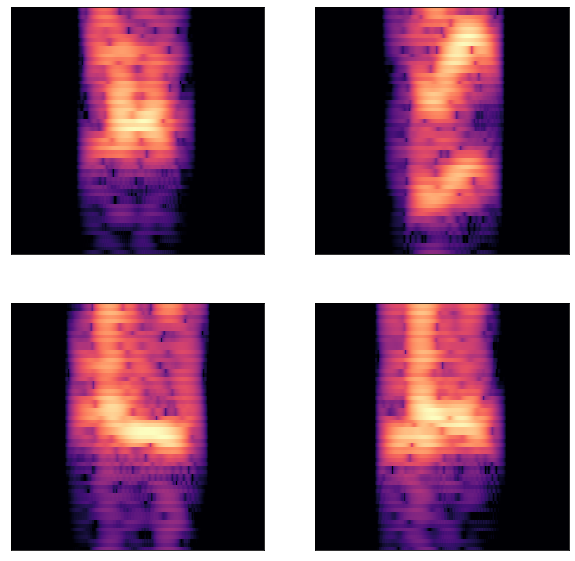

In [39]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    
    y = chop(os.path.join(data_root, spk, f'{file}.wav'), start, dur)
    specshow(y, ax=axs[i])

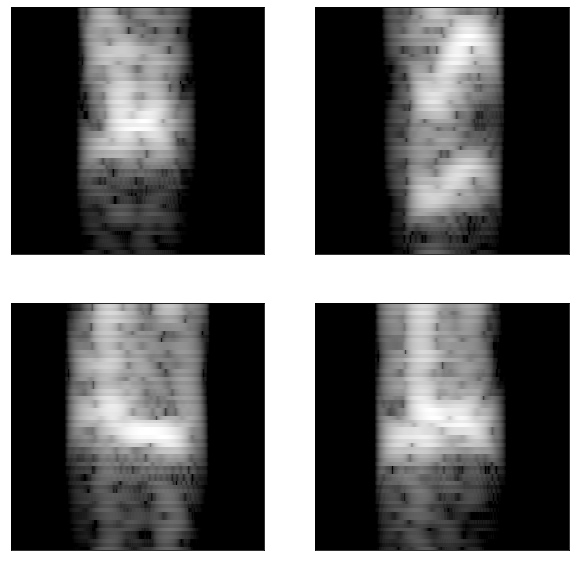

In [40]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    
    y = chop(os.path.join(data_root, spk, f'{file}.wav'), start, dur)
    specshow(y, ax=axs[i], cmap='gray')